## Ramon Brand - Session 4 - NMist with own images and data augmentation
### Overview
The idea of this exercise is to train a neural network using the nmist dataset, and then use the network to predict own hand drawn number images.

We did this before, however now we will use a convolution network and data augmentation to see if we can improve the results of the hand drawn images.

### Part 1 - A baseline network
The first try is with a simple network without data augmentation, but with convolution.

In [8]:
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D

# -- Load Data File
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# -- Shuffle
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)
state = np.random.get_state()
np.random.shuffle(x_test)
np.random.set_state(state)
np.random.shuffle(y_test)

# -- Change type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# -- Reshape
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

# -- Normalize
x_train /= 255
x_test /= 255

# -- Change input to 28 , 28
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# -- Change results to category one hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# -- Extract some validation data from our training data
VALIDATION_SAMPLES = 7500

x_val = x_train[len(x_train) - VALIDATION_SAMPLES:]
x_train = x_train[:len(x_train) - VALIDATION_SAMPLES]
y_val = y_train[len(y_train) - VALIDATION_SAMPLES:]
y_train = y_train[:len(y_train) - VALIDATION_SAMPLES]

# -- Create model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(96, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
hist = model.fit(x_train, y_train, epochs=20, batch_size=256, validation_data=(x_val,y_val))

score = model.evaluate(x_test, y_test)
print("Loss: ", score[0])
print("Accuracy: ", score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 96)          55392     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 864)               0         
__________

In [13]:
# --------------------------------- Predictions

x_predictions = None

# -- Lets do this for some of our test images
for x in range(0, 10):
    # -- Load image
    img = load_img("sample_" + str(x) + ".png")
    imgData = np.array(img)

    # -- Use only first element of deepest child
    imgDataCut = imgData[:,:,0]

    # -- Change type
    imgDataCut = imgDataCut.astype('float32')

    # -- Normalize
    imgDataCut /= 255
    
    # -- Change input to 28 , 28
    imgDataCut = imgDataCut.reshape(28, 28, 1)
    
    # -- Flatten array to match
    #imgDataCut = imgDataCut.flatten()
    
    if x_predictions is None:
        x_predictions = [imgDataCut]
    else:
        x_predictions = np.concatenate((x_predictions, [imgDataCut]))
    
predictionResult = model.predict(x_predictions)    

predictionHotIndex = np.argmax(predictionResult, axis=1)

print("Target: [0 1 2 3 4 5 6 7 8 9]")
print("Result: " + str(predictionHotIndex))

Target: [0 1 2 3 4 5 6 7 8 9]
Result: [0 1 2 3 4 5 6 3 8 7]


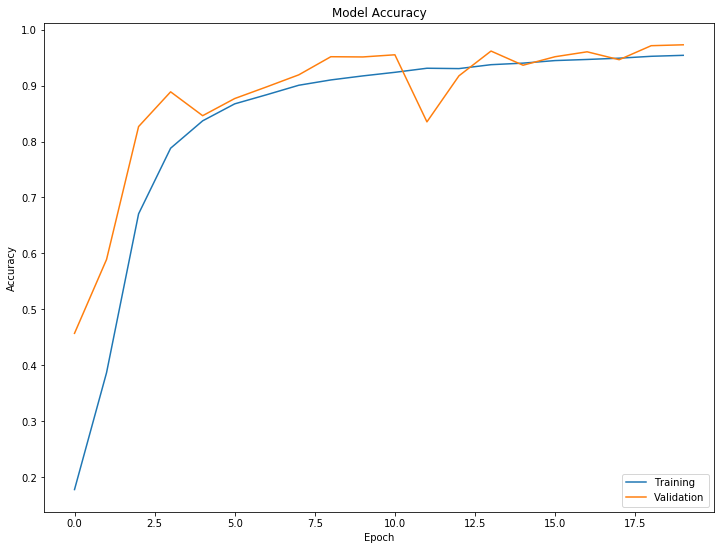

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
#plt.xlim([5,50])
#plt.ylim([0.75,0.94])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()

We managed to get an NMIST test accuracy of 0.97, which is quite good, and out predictions got 8 out of 10 correct, giving us an accuracy of 0.8.

We can do better...

It does look like the model reached capacity, since there is no overfitting, but the graph has plataued, indicating that we should add more capacity to our network. Let's start by adding data augmentation.

### Part 2 - Data augmentation
We now add data augmentation.

In [17]:
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D

# -- Load Data File
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# -- Shuffle
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)
state = np.random.get_state()
np.random.shuffle(x_test)
np.random.set_state(state)
np.random.shuffle(y_test)

# -- Change type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# -- Reshape
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

# -- Normalize
x_train /= 255
x_test /= 255

# -- Change input to 28 , 28
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# -- Change results to category one hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# -- Extract some validation data from our training data
VALIDATION_SAMPLES = 7500

x_val = x_train[len(x_train) - VALIDATION_SAMPLES:]
x_train = x_train[:len(x_train) - VALIDATION_SAMPLES]
y_val = y_train[len(y_train) - VALIDATION_SAMPLES:]
y_train = y_train[:len(y_train) - VALIDATION_SAMPLES]

# -- Create model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(96, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)
train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = train_datagen.flow(x_val, y_val, batch_size=32)

hist2 = model.fit_generator(train_generator, steps_per_epoch=len(x_train) / 32, epochs=20, validation_data=validation_generator,
 validation_steps=50)


#hist = model.fit(x_train, y_train, epochs=20, batch_size=256, validation_data=(x_val,y_val))

score2 = model.evaluate(x_test, y_test)
print("Loss: ", score2[0])
print("Accuracy: ", score2[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 96)          55392     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 96)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 864)               0         
__________

In [18]:
# --------------------------------- Predictions

x_predictions = None

# -- Lets do this for some of our test images
for x in range(0, 10):
    # -- Load image
    img = load_img("sample_" + str(x) + ".png")
    imgData = np.array(img)

    # -- Use only first element of deepest child
    imgDataCut = imgData[:,:,0]

    # -- Change type
    imgDataCut = imgDataCut.astype('float32')

    # -- Normalize
    imgDataCut /= 255
    
    # -- Change input to 28 , 28
    imgDataCut = imgDataCut.reshape(28, 28, 1)
    
    # -- Flatten array to match
    #imgDataCut = imgDataCut.flatten()
    
    if x_predictions is None:
        x_predictions = [imgDataCut]
    else:
        x_predictions = np.concatenate((x_predictions, [imgDataCut]))
    
predictionResult = model.predict(x_predictions)    

predictionHotIndex = np.argmax(predictionResult, axis=1)

print("Target: [0 1 2 3 4 5 6 7 8 9]")
print("Result: " + str(predictionHotIndex))

Target: [0 1 2 3 4 5 6 7 8 9]
Result: [0 1 2 3 4 5 6 7 8 9]


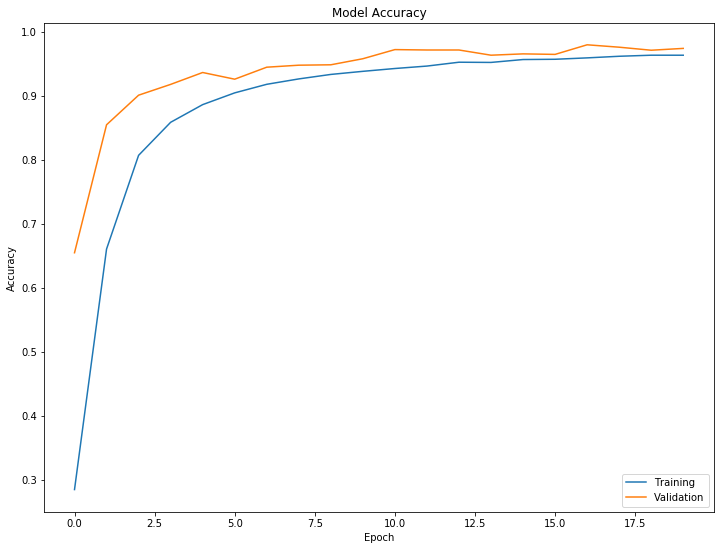

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(hist2.history["acc"])
plt.plot(hist2.history['val_acc'])
#plt.xlim([5,50])
#plt.ylim([0.75,0.94])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()

We got 100% accuracy in our predicitions, with a test accuracy of 0.97, the same as before.

However, this does make sense, because the data augmentation will certainly make the model less strict on the exact shape and thickness of the lines, which is where our hand written data is different. This means that even though against test data from MNIST, the model performs slightly worse, the model is more generalized and performs better with data which looks different to the standard MNIST data.

We can still see that the data levels out, without overfitting, so lets try a higher capacity model.

### Part 3 - Extra high capacity model

In [21]:
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling2D

# -- Load Data File
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# -- Shuffle
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)
state = np.random.get_state()
np.random.shuffle(x_test)
np.random.set_state(state)
np.random.shuffle(y_test)

# -- Change type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# -- Reshape
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

# -- Normalize
x_train /= 255
x_test /= 255

# -- Change input to 28 , 28
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# -- Change results to category one hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# -- Extract some validation data from our training data
VALIDATION_SAMPLES = 7500

x_val = x_train[len(x_train) - VALIDATION_SAMPLES:]
x_train = x_train[:len(x_train) - VALIDATION_SAMPLES]
y_val = y_train[len(y_train) - VALIDATION_SAMPLES:]
y_train = y_train[:len(y_train) - VALIDATION_SAMPLES]

# -- Create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(96, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(60, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False)
train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = train_datagen.flow(x_val, y_val, batch_size=32)

hist3 = model.fit_generator(train_generator, steps_per_epoch=len(x_train) / 32, epochs=20, validation_data=validation_generator,
 validation_steps=50)

score3 = model.evaluate(x_test, y_test)
print("Loss: ", score3[0])
print("Accuracy: ", score3[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 9, 9, 96)          55392     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 128)         110720    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 3, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
__________

In [22]:
# --------------------------------- Predictions

x_predictions = None

# -- Lets do this for some of our test images
for x in range(0, 10):
    # -- Load image
    img = load_img("sample_" + str(x) + ".png")
    imgData = np.array(img)

    # -- Use only first element of deepest child
    imgDataCut = imgData[:,:,0]

    # -- Change type
    imgDataCut = imgDataCut.astype('float32')

    # -- Normalize
    imgDataCut /= 255
    
    # -- Change input to 28 , 28
    imgDataCut = imgDataCut.reshape(28, 28, 1)
    
    # -- Flatten array to match
    #imgDataCut = imgDataCut.flatten()
    
    if x_predictions is None:
        x_predictions = [imgDataCut]
    else:
        x_predictions = np.concatenate((x_predictions, [imgDataCut]))
    
predictionResult = model.predict(x_predictions)    

predictionHotIndex = np.argmax(predictionResult, axis=1)

print("Target: [0 1 2 3 4 5 6 7 8 9]")
print("Result: " + str(predictionHotIndex))

Target: [0 1 2 3 4 5 6 7 8 9]
Result: [0 1 2 3 4 5 6 7 8 9]


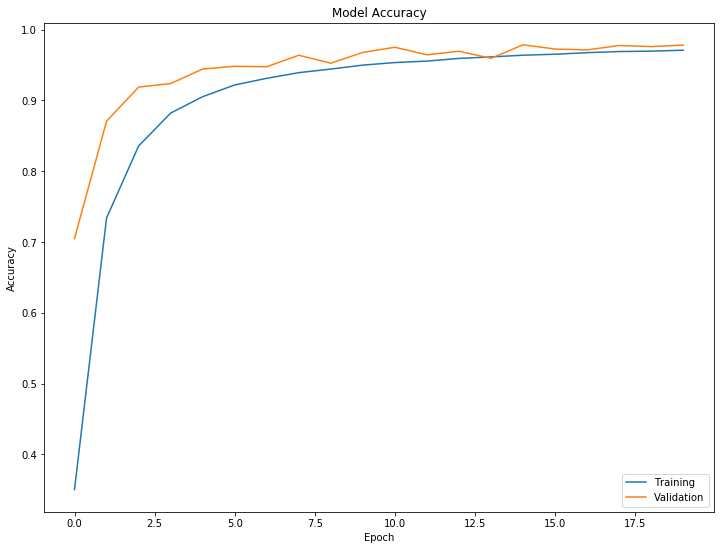

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(hist3.history["acc"])
plt.plot(hist3.history['val_acc'])
#plt.xlim([5,50])
#plt.ylim([0.75,0.94])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()

As expected the higher capacity network managed to get a slightly better accuracy at 0.978, which is pretty good I think.